## DataGeneration class 를 이용한 Wine 구현

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

np.random.seed(0)

In [2]:
# 수치미분 함수

def numerical_derivative(f, x):
    delta_x = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    
    while not it.finished:
        idx = it.multi_index        
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + delta_x
        fx1 = f(x) # f(x+delta_x)
        
        x[idx] = tmp_val - delta_x 
        fx2 = f(x) # f(x-delta_x)
        grad[idx] = (fx1 - fx2) / (2*delta_x)
        
        x[idx] = tmp_val 
        it.iternext()   
        
    return grad

# sigmoid 함수

def sigmoid(x):
    return 1 / (1+np.exp(-x))

#### Wine class 구현

In [3]:
# Wine Class

class Wine:
    
    # 생성자
    # xdata, tdata => numpy.array(...)
    def __init__(self, name, input_nodes, hidden_nodes, output_nodes, learning_rate):
        
        self.name = name
        
        # 2층 hidden layer unit 
        # 가중치 W, 바이어스 b 초기화
        self.W2 = np.random.rand(input_nodes, hidden_nodes)  
        self.b2 = np.random.rand(hidden_nodes)
        
        # 3층 hidden layer unit  
        self.W3 = np.random.rand(hidden_nodes, output_nodes)
        self.b3 = np.random.rand(output_nodes)
                        
        # 학습률 learning rate 초기화
        self.learning_rate = learning_rate
        
        print(self.name, " is created !!!")
        
    # 손실함수
    def feed_forward(self):
        
        delta = 1e-7    # log 무한대 발산 방지
    
        z2 = np.dot(self.input_data, self.W2) + self.b2
        a2 = sigmoid(z2)
        
        z3 = np.dot(a2, self.W3) + self.b3
        y = a3 = sigmoid(z3)
            
        # cross-entropy 
        return  -np.sum( self.target_data*np.log(y + delta) + (1-self.target_data)*np.log((1 - y)+delta ) )
    
    # 손실 값 계산
    def loss_val(self):
        
        delta = 1e-7    # log 무한대 발산 방지
    
        z2 = np.dot(self.input_data, self.W2) + self.b2
        a2 = sigmoid(z2)
        
        z3 = np.dot(a2, self.W3) + self.b3
        y = a3 = sigmoid(z3)
            
        # cross-entropy 
        return  -np.sum( self.target_data*np.log(y + delta) + (1-self.target_data)*np.log((1 - y)+delta ) )
    
    # query, 즉 미래 값 예측 함수
    def predict(self, input_data):    
        
        z2 = np.dot(input_data, self.W2) + self.b2
        a2 = sigmoid(z2)
        
        z3 = np.dot(a2, self.W3) + self.b3
        y = a3 = sigmoid(z3)
        
    
        if y >= 0.5:
            result = 1  # True
        else:
            result = 0  # False
    
        return y, result
    
    def accuracy(self, input_data, target_data):
        
        matched_list = []
        not_matched_list = []
        
        for index in range(len(input_data)):
            
            (real_val, logical_val) = self.predict(input_data[index])
            
            if logical_val == target_data[index]:
                matched_list.append(index)
            else:
                not_matched_list.append(index)
                
        accuracy_result = len(matched_list) / len(input_data)
        
        print("Accuracy => ", accuracy_result)
        
        return matched_list, not_matched_list
    
        
    # 수치미분을 이용하여 손실함수가 최소가 될때 까지 학습하는 함수
    def train(self, input_data, target_data):
        
        self.input_data = input_data
        self.target_data = target_data
        
        f = lambda x : self.feed_forward()
        
        self.W2 -= self.learning_rate * numerical_derivative(f, self.W2)
    
        self.b2 -= self.learning_rate * numerical_derivative(f, self.b2)
        
        self.W3 -= self.learning_rate * numerical_derivative(f, self.W3)
    
        self.b3 -= self.learning_rate * numerical_derivative(f, self.b3)

#### DataGeneration class 구현

In [4]:
class DataGeneration:
    
    def __init__(self, name, file_path, seperation_rate):
        
        self.name = name
        
        self.file_path = file_path
        
        self.seperation_rate = seperation_rate
        
    # numpy.random.shuffle()  이용하여 training_data / test_data 생성
    def generate(self):
    
        # 데이터 불러오기, 파일이 없는 경우 exception 발생

        try:
            loaded_data = np.loadtxt(self.file_path, delimiter=',', dtype=np.float32)
            
        except Exception as err:
            print('[DataGeneration::generate()]  ', str(err))
            raise Exception(str(err))

        print("[DataGeneration]  loaded_data.shape = ", loaded_data.shape)
        
        
        # 분리비율에 맞게 테스트데이터로 분리
        total_data_num = len(loaded_data)
        test_data_num = int(len(loaded_data) * self.seperation_rate)

        # numpy.random.shuffle 을 이용하여 랜덤하게 데이터 섞기
        np.random.shuffle(loaded_data)
        
        # test_data 는 0 : test_data_num
        
        test_data = loaded_data[ 0:test_data_num ]

        # training_data 는 test_data_num 부터 끝까지 
        training_data = loaded_data[ test_data_num: ]

        
        return training_data, test_data

#### DataGeneration 객체를 통한 training_data , test_data 생성

In [5]:
# DataGeneration 객체 생성.
seperation_rate = 0.3 # 분리비율

data_obj = DataGeneration('Wine', './(200309)Wine.csv', seperation_rate)

(training_data, test_data) = data_obj.generate()

[DataGeneration]  loaded_data.shape =  (6497, 13)


#### Diabetes 객체 생성 및 학습

In [7]:
#hyper-parameter
i_nodes = training_data.shape[1] - 1    # input nodes 개수
h_nodes = 5  # hidden nodes 개수. 
o_nodes = 1    # output nodes 개수
lr = 1e-4      
epochs = 20   # 반복횟수. 

# 손실함수 값 저장
loss_val_list = []

# Wine 객체 생성
obj = Wine("Wine", i_nodes, h_nodes, o_nodes, lr)

print("Neural Network Learning using Numerical Derivative...")

start_time = datetime.now()

for step in range(epochs):
    
    for index in range(len(training_data)):
        
        input_data = training_data[index, 0:-1]
        target_data = training_data[index, [-1]]
        
        obj.train(input_data, target_data)
        
    cur_loss_val = obj.loss_val()
    print("epochs = ", step, "loss value = ", cur_loss_val)
    loss_val_list.append(cur_loss_val)

end_time = datetime.now()
        
print("")
print("Elapsed Time => ", end_time - start_time)

Wine  is created !!!
Neural Network Learning using Numerical Derivative...
epochs =  0 loss value =  1.484895918140309
epochs =  1 loss value =  0.7594846614296484
epochs =  2 loss value =  0.49641864876821756
epochs =  3 loss value =  0.3904533451545536
epochs =  4 loss value =  0.3407336243943368
epochs =  5 loss value =  0.31491935138295163
epochs =  6 loss value =  0.30068184744418786
epochs =  7 loss value =  0.29254431869118663
epochs =  8 loss value =  0.2877939641184524
epochs =  9 loss value =  0.2849857849691553
epochs =  10 loss value =  0.283313183727461
epochs =  11 loss value =  0.28231244565539554
epochs =  12 loss value =  0.28171206572952334
epochs =  13 loss value =  0.28135128760684636
epochs =  14 loss value =  0.2811342772445176
epochs =  15 loss value =  0.2810036669632418
epochs =  16 loss value =  0.2809250296284623
epochs =  17 loss value =  0.2808776738179492
epochs =  18 loss value =  0.2808491522222907
epochs =  19 loss value =  0.2808319728168495

Elapsed T

#### 손실함수 값 그리기

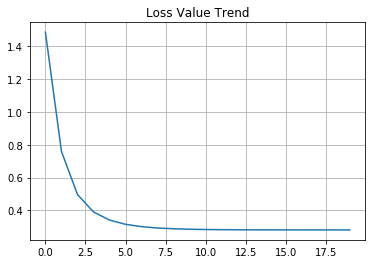

In [8]:
plt.title('Loss Value Trend')
plt.grid()
plt.plot(loss_val_list)

plt.show()

#### test_data를 이용하여 정확도 검증

In [9]:
test_input_data = test_data[ :, 0:-1 ]
test_target_data = test_data[ :, -1 ]

(true_list, false_list) = obj.accuracy(test_input_data, test_target_data) 

Accuracy =>  0.7547460236018471
